In [6]:
import torch
from CNN.models import MlpRegBaseline
from CNN.datasets import Reg_Seq_Dataset
from CNN.datasets import load_reg_seq_data
from CNN.datasets import sig_denorm, li_denorm, custom_denorm
import matplotlib.pylab as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [7]:
# useful functions:
def renorm(data, mean, std):
    data = torch.logit(data)
    data = data*std+mean
    return torch.log(data)


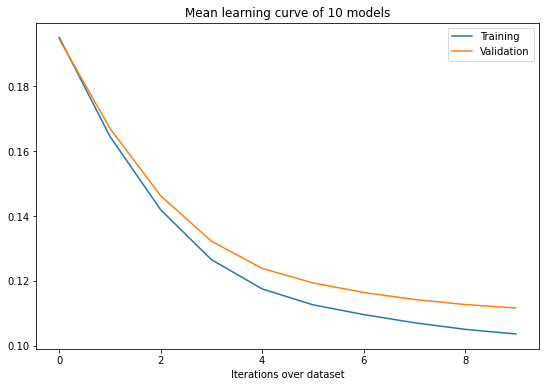

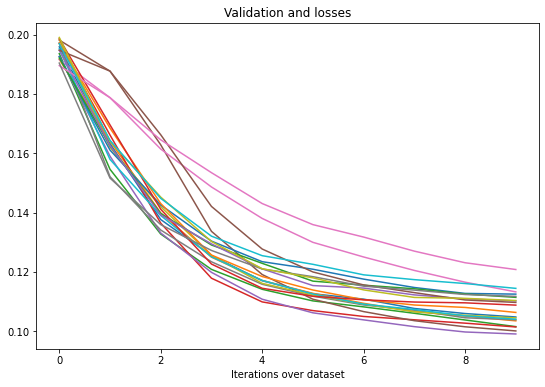

In [9]:
# models_path = "/home/daqop/Desktop/M2/Internship/python/trained_models/"
# models_path = "/home/daqop/mountpoint_snellius/3D-Vac/src/5_train_models/CNN/I/reg/seq/trained_models/"
models_path = "/home/daqop/train_branch_3D_Vac/src/5_train_models/CNN/I/reg/seq/trained_models/"
models_path = models_path + "mlp_reg_baseline_5_neurons_10_epochs_test.pt"
cp = torch.load(models_path)
xval_data = cp["models_data"]
a = cp["arguments"]

train_losses = torch.tensor([data["train_losses"] for data in xval_data])
validation_losses = torch.tensor([data["validation_losses"] for data in xval_data])
train_losses = torch.permute(train_losses, (1,0))
validation_losses = torch.permute(validation_losses, (1,0))

#plot mean validation and loss
plt.figure(figsize=(9,6))
plt.plot(range(a.epochs), train_losses.mean(dim=1))
plt.plot(range(a.epochs), validation_losses.mean(dim=1))
plt.title("Validation and losses")
plt.xlabel("Iterations over dataset")
plt.title("Mean learning curve of 10 models")
plt.legend(["Training", "Validation"])
plt.show()

#plot the actual validation and loss
plt.figure(figsize=(9,6))
plt.plot(range(a.epochs), train_losses)
plt.plot(range(a.epochs), validation_losses)
plt.title("Validation and losses")
plt.xlabel("Iterations over dataset")
plt.show()

In [11]:

# plot the r-squared and other metrics for each model
all_indices = []
csv_peptides, csv_ba_values = load_reg_seq_data("../../data/binding_data/BA_pMHCI.csv", a.threshold)
dataset = Reg_Seq_Dataset(csv_peptides, csv_ba_values, a.encoder)
r_scores = []
for data in xval_data:
    # load the model and data
    model = MlpRegBaseline(neurons_per_layer=a.neurons) 
    model.load_state_dict(data["model"])
    model.eval()

    test_X = dataset.peptides[data["test_indices"]]
    test_ba = dataset.ba_values[data["test_indices"]]

    with torch.no_grad():
        # make the prediction on the test dataset
        test_pred_ba = torch.reshape(model(test_X), (-1,))
        if a.normalize_function == "sigmoid":
            test_pred_ba = sig_denorm(test_pred_ba, data["renorm_values"]["training_mean"], data["renorm_values"]["training_std"])
        if a.normalize_function == "li":
            test_pred_ba = li_denorm(test_pred_ba, data["renorm_values"]["training_max"], data["renorm_values"]["training_min"])

    test_r = r2_score(test_ba, test_pred_ba)
    r_scores.append(test_r)
r_scores = torch.tensor(r_scores)
print(r_scores.mean())

tensor(0.0551, dtype=torch.float64)
